# 3D video of training dynamics

In [1]:
using Printf, LinearAlgebra
using JLD2 
using GLMakie
using MyTwoLayerNN

include("../experimentplots.jl")

createorientiationplot (generic function with 1 method)

In [2]:
MYORANGE = Makie.RGB(213/255, 94/255, 0/255)

Create the NN

In [3]:
# Data parameters
d = 1
dataX = [[-1/2], [-1/6], [1/6], [1/2]]
dataY = [1/4, 1/30, 1/30, 1/4]

# NN parameters
m = 1_000
γ = 1.5
γ′ = -0.5

nn = TwoLayerNN(d, m, γ, γ′)

# Create copy of inital weights 
initialNN = copy(nn)

# Training parameters
learning_rate = 4000.0
max_steps = 100_000_000

training_data = TrainingData(dataX, dataY, learning_rate, max_steps)

TrainingData{Float64, Int64}([[-0.5], [-0.16666666666666666], [0.16666666666666666], [0.5]], [0.25, 0.03333333333333333, 0.03333333333333333, 0.25], 4000.0, 100000000)

Create callback function

In [233]:
w_norms::Vector{Float64} = [norm(nn.w)]
b_norms::Vector{Float64} = [norm(nn.b)]
a_norms::Vector{Float64} = [norm(nn.a)]

function mycallback(nn, step, loss)
    if step % 1000 == 0
        push!(w_norms, norm(nn.w))
        push!(b_norms, norm(nn.b))
        push!(a_norms, norm(nn.a))
    end
end

mycallback (generic function with 1 method)

Train the NN

In [234]:
train!(nn, training_data; callback=mycallback)

Number of steps: 163288


## Some simple visualizations 

In [68]:
f = Figure()
ax = Axis(f[1, 1])

createlineplot!(ax, nn, training_data)

f |> display

GLMakie.Screen(...)

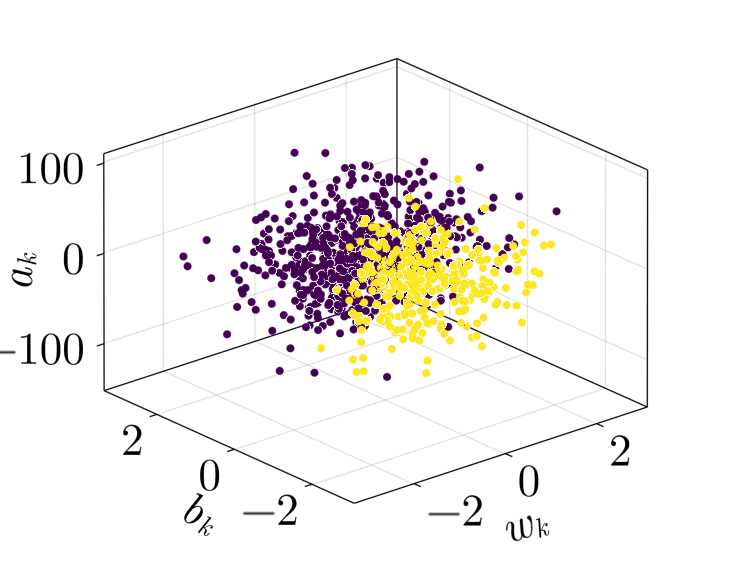

In [45]:
f = Figure()
ax = Axis3(f[1, 1], xlabel=L"w_k", ylabel=L"b_k", zlabel=L"a_k")

xmin, xmax = dataX |> Iterators.flatten |> extrema
dead_neurons = [(b ≤ -w * xmin) && (b ≤ -w * xmax) for (w, b) in zip(nn.w, nn.b)]

scatter!(ax, vec(nn.w), nn.b, nn.a, color=dead_neurons)

f

In [225]:
f = Figure()

xmin, xmax = dataX |> Iterators.flatten |> extrema
dead_neurons = [(b ≤ -w * xmin) && (b ≤ -w * xmax) ? :gray : MYORANGE for (w, b) in zip(nn.w, nn.b)]

sl = Slider(f[2, 1], range = 0:0.1:100, startvalue = 5)

ax = Axis3(f[1, 1], xlabel=L"w_k", ylabel=L"b_k", zlabel=L"a_k", viewmode=:fit)
scat = scatter!(ax, vec(nn.w), nn.b, nn.a, color=dead_neurons)

xyzmin = [-50.0, -50.0, -200.0]
xyzmax = [50.0, 50.0, 200.0]

xlims!(ax, xyzmin[1], xyzmax[1])
ylims!(ax, xyzmin[2], xyzmax[2])
zlims!(ax, xyzmin[3], xyzmax[3])

on(events(ax.scene).scroll, priority=5) do (dx, dy)
    zoomamount = [0.9, 0.9, 0.9]

    kb = events(ax.scene).keyboardbutton[]

    if kb.action == Keyboard.repeat
        if kb.key == Keyboard.x
            zoomamount = [0.9, 1.0, 1.0]
        elseif kb.key == Keyboard.y
            zoomamount = [1.0, 0.9, 1.0]
        elseif kb.key == Keyboard.z
            zoomamount = [1.0, 1.0, 0.9]
        end
    end 

    if dy > 0
        xyzmin .*= zoomamount
        xyzmax .*= zoomamount    
    elseif dy < 0
        xyzmin ./= zoomamount
        xyzmax ./= zoomamount
    end

    if !iszero(dy)
        xlims!(ax, xyzmin[1], xyzmax[1])
        ylims!(ax, xyzmin[2], xyzmax[2])
        zlims!(ax, xyzmin[3], xyzmax[3])
    end
end

display(f)

GLMakie.Screen(...)

## Create 3D video

In [86]:
# Makie.RGB(213/255, 94/255, 0/255) # Nice orange
theme_2plot_vid = merge(theme_latexfonts(),
    Theme(
        fontsize = 36,
        Lines = (
            color = Makie.RGB(213/255, 94/255, 0/255),
            cycle = [],
            linewidth = 3,
        ),
        Scatter = (
            markersize = 16,
        )
    )
);

In [229]:
function movie_multiple_plots(; nn::TwoLayerNN, learning_rate, 
    xlim = nothing, ylim = nothing, zlim = nothing, total_epochs = 100_000, 
    epochs_between_frames = 1000, framerate = 10, file_name="vid.mp4", rotate = true
)
    with_theme(theme_2plot_vid) do # Start theme

    # Determine minimum and maximum x-values
    xmin, xmax = dataX |> Iterators.flatten |> extrema
    xvals = range(xmin, xmax, length=100)

    # -----------------------
    # Create observables
    # -----------------------

    # Scatter plot observables 
    wobs = Observable(vec(nn.w))
    bobs = Observable(nn.b)
    aobs = Observable(nn.a)
    deobs = Observable([(b ≤ -w * xmin) && (b ≤ -w * xmax) ? :gray : MYORANGE for (w, b) in zip(nn.w, nn.b)]) # Dead neurons
    azobs = Observable(1.275π) # Azimuth angle

    # Line plot observables
    yobs = Observable([forward(nn, p) for p in xvals])
    iobs = Observable(-nn.b ./ vec(nn.w))
    iyobs = Observable([forward(nn, p) for p in iobs[]])

    # General observables
    time = Observable(0.0)

    # -----------------------
    # Create figure
    # -----------------------
    fig = Figure(size = (1500, 750))
    ax = Axis3(fig[1, 1], xlabel=L"w_k", ylabel=L"b_k", zlabel=L"a_k", viewmode=:fit, azimuth=azobs)

    # Create initial scatter plot
    scat = scatter!(ax, wobs, bobs, aobs, color=deobs)

    # Set axis limits
    !isnothing(xlim) && xlims!(ax, xlim...)
    !isnothing(ylim) && ylims!(ax, ylim...)
    !isnothing(zlim) && zlims!(ax, zlim...)

    # Create initial line plot
    ax2 = Axis(fig[1, 2])
    lines!(ax2, xvals, yobs)
    scatter!(ax2, vcat(dataX...), dataY)
    scatter!(ax2, iobs, iyobs, marker=:star5, color=:darkgreen)
    xlims!(ax2, -0.55, 0.55)

    # Create figure title
    Label(fig[0, :], @lift("m = $(length(nn.b)), α = $(nn.α), t = $(@sprintf "%.1e" $time)"), fontsize = 40)

    # -----------------------
    # Create movie
    # -----------------------

    # Movie parameters
    timestamps = range(0, total_epochs / (epochs_between_frames * framerate), step=1/framerate)

    # Training data 
    training_data = TrainingData(dataX, dataY, learning_rate, epochs_between_frames)

    # Create video
    record(fig, file_name, timestamps; framerate = framerate) do t
        # Train NN from t > 0
        !iszero(t) && train!(nn, training_data; stop_tol = false)

        # Update scatter plot data
        wobs[] = vec(nn.w)
        bobs[] = nn.b
        aobs[] = nn.a
        deobs[] = [(b ≤ -w * xmin) && (b ≤ -w * xmax) ? :gray : MYORANGE for (w, b) in zip(nn.w, nn.b)]
        rotate && (azobs[] = azobs[] - 2π / (framerate * 10))

        # Update line plot data
        yobs[] = [forward(nn, p) for p in xvals]
        iobs[] = -nn.b ./ vec(nn.w)
        iyobs[] = [forward(nn, p) for p in iobs[]]

        # Update title
        time[] = t * framerate * epochs_between_frames * learning_rate
    end
    end # end theme
end

movie_multiple_plots (generic function with 1 method)

### Concrete settings

In [231]:
# Wide
movie_multiple_plots(
    nn = TwoLayerNN(d, 1000, 1.5, -0.5),
    learning_rate = 4000.0,
    xlim = (-490, 490), # w
    ylim = (-151, 81), # b
    zlim = (-50, 591), # a
    total_epochs = 180_000, # 164_000
    epochs_between_frames = 1000 ÷ 3,
    framerate = 30,
    file_name = "wide.mp4"
)

"test a-lag wide 3d.mp4"

In [122]:
# Begin
movie_multiple_plots(
    nn = TwoLayerNN(d, 1000, 1.5, -0.5),
    learning_rate = 4000.0,
    xlim = (-490, 490), # w
    ylim = (-151, 81), # b
    zlim = (-50, 591), # a
    total_epochs = 10_000,
    epochs_between_frames = 100,
    framerate = 10,
    file_name = "begin a-lag wide 3d.mp4"
)

"begin a-lag wide 3d.mp4"

In [230]:
# Begin close
movie_multiple_plots(
    nn = TwoLayerNN(d, 1000, 1.5, -0.5),
    learning_rate = 1000.0,
    xlim = (-49, 49), # w
    ylim = (-49, 49), # b
    zlim = (-200, 200), # a
    total_epochs = 10_000,
    epochs_between_frames = 15 ÷ 3,
    framerate = 30,
    file_name = "begin close.mp4"
)

"fixed begin close.mp4"

In [223]:
# Begin tiny
movie_multiple_plots(
    nn = TwoLayerNN(d, 1000, 1.5, -0.5),
    learning_rate = 1000.0,
    xlim = (-5, 5), # w
    ylim = (-5, 5), # b
    zlim = (-200, 200), # a
    total_epochs = 10_000,
    epochs_between_frames = 15 ÷ 3,
    framerate = 30,
    file_name = "begin tiny.mp4"
)

"begin tiny.mp4"